In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 7)
plt.set_cmap("viridis")

import itertools
import numpy as np

import theano
import theano.tensor as T

In [2]:
from carl.distributions import Normal, Uniform, Mixture

In [3]:
true_amp, true_mass, true_width = .2, 0., 0.3

amp = theano.shared(true_amp) 
mass = theano.shared(true_mass) 
width = theano.shared(true_width)

components = [
    Normal(mu=mass, sigma=width),   # c0
    Uniform(low=-5,high=5),
]

components_ref = [
    Normal(mu=1., sigma=.75),   # c0
    Uniform(low=-5,high=5),
]


p0 = Mixture(components=components, weights=[amp, 1-amp])
p1 = Mixture(components=components[1:], weights=[1])
pref = Mixture(components=components_ref, weights=[.3, .7])

In [4]:
N_obs = 500
X_true = p0.rvs(N_obs)

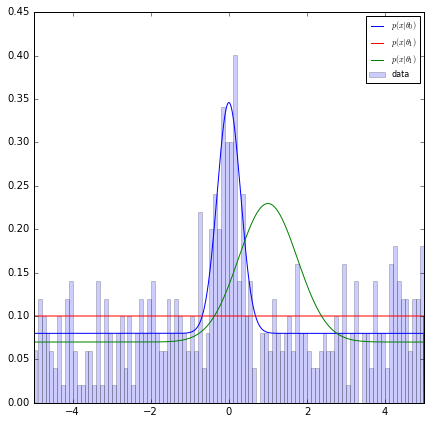

In [5]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_0)$", color="b")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_1)$", color="r")
plt.plot(reals, pref.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_1)$", color="g")

plt.hist(X_true[:, 0], bins=100, normed=True, label="data", alpha=0.2, color="b")
plt.xlim(-5, 5)
plt.legend(loc="best", prop={'size': 8})
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from carl.ratios import ClassifierRatio
from carl.ratios import DecomposedRatio
from carl.learning import CalibratedClassifierCV
from scipy.stats import chi2

# Classifier
# from sklearn.linear_model import ElasticNetCV
# clf = ElasticNetCV()

from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(activation="tanh", hidden_layer_sizes=(10, 10))

clf_base = MLPRegressor(tol=1e-05, activation="relu", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)

clf=clf_base

n_train_samples = 1000000
n_calibration_samples = 1000000


# from sklearn.ensemble import ExtraTreesRegressor
# clf = ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)

# No calibration
cc_none = ClassifierRatio(base_estimator=clf)
cc_none.fit(numerator=p0, denominator=p1, n_samples=n_train_samples)

# Calibration + Direct approximation 
cv = StratifiedShuffleSplit(n_iter=1, test_size=0.75)  # 25% for training, 75% for calibration
cc_direct = ClassifierRatio(base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=150))
cc_direct.fit(numerator=p0, denominator=p1, n_samples=n_train_samples)

# Calibration + Decomposition of the mixture
cc_decomposed = DecomposedRatio(ClassifierRatio(base_estimator=CalibratedClassifierCV(clf, cv=cv)))
cc_decomposed.fit(numerator=p0, denominator=p1, n_samples=n_calibration_samples)

DecomposedRatio(base_ratio=ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=MLPRegressor(activation='relu', algorithm='l-bfgs', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constant', learning_rate_init=1e-07, ...=1, random_state=None, test_size=0.75,
            train_size=None),
            method='histogram'),
        random_state=None))

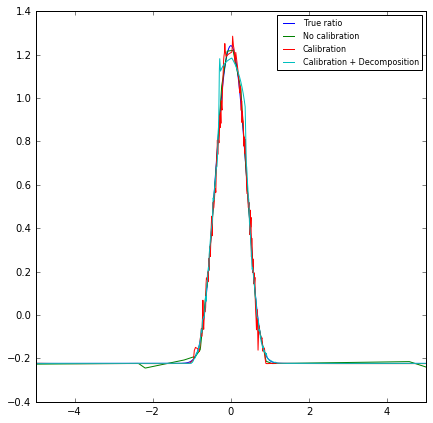

In [11]:
plt.plot(reals, -p0.nnlf(reals.reshape(-1, 1))  
                +p1.nnlf(reals.reshape(-1, 1)), label="True ratio")

plt.plot(reals, cc_none.predict(reals.reshape(-1, 1), log=True), label="No calibration")
plt.plot(reals, cc_direct.predict(reals.reshape(-1, 1), log=True), label="Calibration")
plt.plot(reals, cc_decomposed.predict(reals.reshape(-1, 1), log=True), label="Calibration + Decomposition")

plt.xlim(-5, 5)
#plt.ylim(-0.5, 0.5)
plt.legend(loc="best", prop={'size': 8})
plt.show()

## Build parametrized classifier in mass, width

In [13]:
from carl.learning import as_classifier
from carl.learning import make_parameterized_classification
from carl.learning import ParameterizedClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [81]:
# Build classification data
X, y = make_parameterized_classification(
    p0, p1,
    n_train_samples, 
    [(mass, np.linspace(-2, 2, num=20)), 
     (width, np.linspace(0.001, 2, num=20))])

clf_base = MLPRegressor(tol=1e-05, activation="relu", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)

# Train parameterized classifier
clf = ParameterizedClassifier(
    make_pipeline(StandardScaler(), 
                  as_classifier(clf_base)),
    [mass, width])
clf.fit(X, y)

ParameterizedClassifier(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='relu', algorithm='l-bfgs', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(1...
       shuffle=True, tol=1e-05, validation_fraction=0.1, verbose=False,
       warm_start=False)))]),
            params=[<TensorType(float64, scalar)>, <TensorType(float64, scalar)>])

In [24]:
# build calibrated ratio from parametrized classifier
cc_parametrized_ratio = ClassifierRatio(CalibratedClassifierCV(
    base_estimator=clf, 
    cv="prefit",  # keep the pre-trained classifier
    method="histogram", bins=70))
cc_parametrized_ratio.fit(numerator=p0, denominator=p1, n_samples=n_calibration_samples)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=ParameterizedClassifier(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='relu', algorithm='l-bfgs', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, ea...start=False)))]),
            params=[<TensorType(float64, scalar)>, <TensorType(float64, scalar)>]),
            bins=70, cv='prefit', method='histogram'),
        random_state=None)

1000
1000
[ 0.80483825]


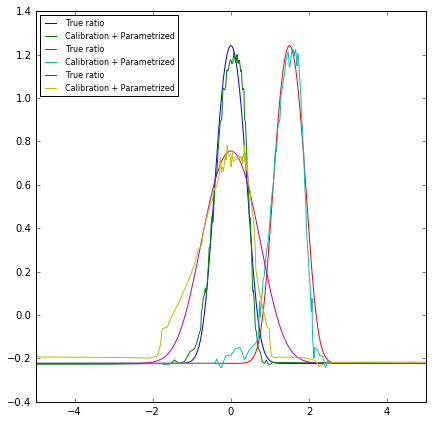

In [25]:
mass.set_value(true_mass)
width.set_value(true_width)
cc_parametrized_ratio.fit(numerator=p0, denominator=p1, n_samples=n_calibration_samples)
plt.plot(reals, -p0.nnlf(reals.reshape(-1, 1))  
                +p1.nnlf(reals.reshape(-1, 1)), label="True ratio")
plt.plot(reals, cc_parametrized_ratio.predict(reals.reshape(-1, 1), log=True), label="Calibration + Parametrized")


mass.set_value(1.5)
width.set_value(true_width)
cc_parametrized_ratio.fit(numerator=p0, denominator=p1, n_samples=n_calibration_samples)
plt.plot(reals, -p0.nnlf(reals.reshape(-1, 1))  
                +p1.nnlf(reals.reshape(-1, 1)), label="True ratio")
plt.plot(reals, cc_parametrized_ratio.predict(reals.reshape(-1, 1), log=True), label="Calibration + Parametrized")

print(np.sum(np.isfinite(cc_parametrized_ratio.predict(reals.reshape(-1, 1), log=True))))


mass.set_value(true_mass)
width.set_value(true_width*2)
cc_parametrized_ratio.fit(numerator=p0, denominator=p1, n_samples=n_calibration_samples)
plt.plot(reals, -p0.nnlf(reals.reshape(-1, 1))  
                +p1.nnlf(reals.reshape(-1, 1)), label="True ratio")
plt.plot(reals, cc_parametrized_ratio.predict(reals.reshape(-1, 1), log=True), label="Calibration + Parametrized")

print(np.sum(np.isfinite(cc_parametrized_ratio.predict(reals.reshape(-1, 1), log=True))))


print(cc_parametrized_ratio.predict(reals.reshape(-1, 1).max()))
plt.xlim(-5, 5)
#plt.ylim(-0.5, 0.5)
plt.legend(loc="best", prop={'size': 8})
plt.show()

## Optimization on true likelihood

In [26]:
from scipy.optimize import minimize
from GPyOpt.methods import BayesianOptimization

In [27]:
# range for fits
mass_min, mass_max = -1,1
width_min, width_max = 0.1, 0.5

In [28]:
# make meshgrid for plots
mass.set_value(true_mass)
width.set_value(true_width)

As = np.linspace(mass_min, mass_max, 100)
Bs = np.linspace(width_min, width_max, 100)
AA, BB = np.meshgrid(As, Bs)
X = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

In [29]:
def vectorize(func):
    def wrapper(X):
        v = np.zeros(len(X))
        
        for i, x_i in enumerate(X):
            v[i] = func(x_i)
            
        return v.reshape(-1, 1)
    
    return wrapper

In [30]:
def true_objective(x):
    mass.set_value(x[0])
    width.set_value(x[1])
    return (p0.nnlf(X_true) - p1.nnlf(X_true)).sum()

In [31]:
# scipy optimize
r = minimize(true_objective, x0=[true_mass, true_width])
true_MLE = r.x

print(r.message, r.success)

print("True MLE =", true_MLE)

Optimization terminated successfully. True
True MLE = [-0.02531864  0.27620325]


In [32]:
solver = BayesianOptimization(vectorize(true_objective), [(mass_min, mass_max), (width_min, width_max)])
solver.run_optimization(max_iter=50, true_gradients=False)

*Optimization completed:
   -Maximum number of iterations reached.


1

In [33]:
true_bo_mle = solver.x_opt

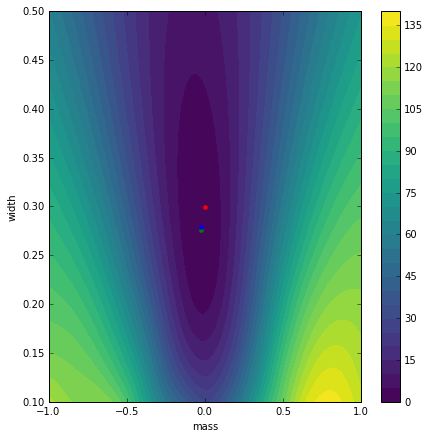

In [34]:
# True contours
true_contours = np.zeros(len(X))
i = 0
for a in As:    
    for b in Bs:
        true_contours[i] = true_objective([a,b])
        i += 1
        
true_nll_at_min = true_contours.min()
true_contours -= true_nll_at_min
        
plt.contourf(As, Bs, true_contours.reshape(AA.shape).T, 30) #50, vmin=0, vmax=12)
plt.colorbar()
plt.xlabel("mass")
plt.ylabel("width")
plt.plot([true_MLE[0]], [true_MLE[1]], "g.", markersize=8)
plt.plot([true_mass], [true_width], "r.", markersize=8)
plt.plot([true_bo_mle[0]], [true_bo_mle[1]], "b.", markersize=8)
plt.axis((mass_min, mass_max, width_min, width_max))
plt.show()

In [35]:
true_objective([true_mass, true_width])-true_nll_at_min

0.44631267026160515

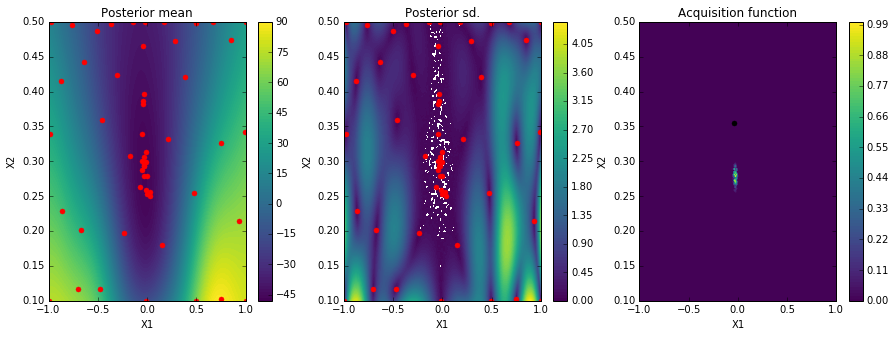

In [36]:
solver.plot_acquisition()

## Optimization on approximate likelihood

In [37]:
def classifier_objective(theta, random_state=0): 
    print(theta)
    
    # Set parameter values   
    mass.set_value(theta[0])
    width.set_value(theta[1])

    # Fit ratio
    ratio = cc_parametrized_ratio
    ratio.fit(numerator=p0, denominator=p1, n_samples=n_calibration_samples)

    # Evaluate log-likelihood ratio
    r = ratio.predict(X_true, log=True)
    value = -np.sum(r[np.isfinite(r)])

    return value

In [38]:
solver = BayesianOptimization(vectorize(classifier_objective), [(mass_min, mass_max), (width_min, width_max)])
solver.run_optimization(max_iter=50, true_gradients=False)

[ 0.47332909  0.13346549]
[ 0.55609172  0.1233185 ]
[-0.3974877   0.29386576]
[ 0.49251118  0.2323974 ]
[ 0.11282389  0.36619663]
[ 0.85547874  0.21811256]
[ 0.29205301  0.5       ]
[-0.03166382  0.5       ]
[-0.00118765  0.46670565]
[-1.   0.5]
[-0.07552903  0.3472553 ]
[-0.15904307  0.1       ]
[-0.22007916  0.4673312 ]
[-1.   0.1]
[-0.06187005  0.39353122]
[-0.09834982  0.37641952]
[ 1.   0.5]
[ 0.67572463  0.5       ]
[-0.68819879  0.5       ]
[-0.02595902  0.3493845 ]
[-0.06251202  0.35183987]
[-0.07728125  0.38118568]
[-0.07108522  0.38231153]
[-0.06776311  0.38026848]
[-0.07277434  0.37543949]
[-0.06738304  0.37336881]
[-0.06900405  0.379182  ]
[-0.07231161  0.37474287]
[-0.07839036  0.36698358]
[-0.04181167  0.42348321]
[-0.0300031   0.33619808]
[-0.0598885   0.35694876]
[-0.05714741  0.35346288]
[-0.059027    0.36003388]
[-0.06126     0.35707596]
[-0.0596778   0.35848496]
[-0.05802594  0.35774341]
[-0.05877147  0.35773903]
[-0.05378972  0.35460884]
[-0.05094138  0.35056707]
[-

1

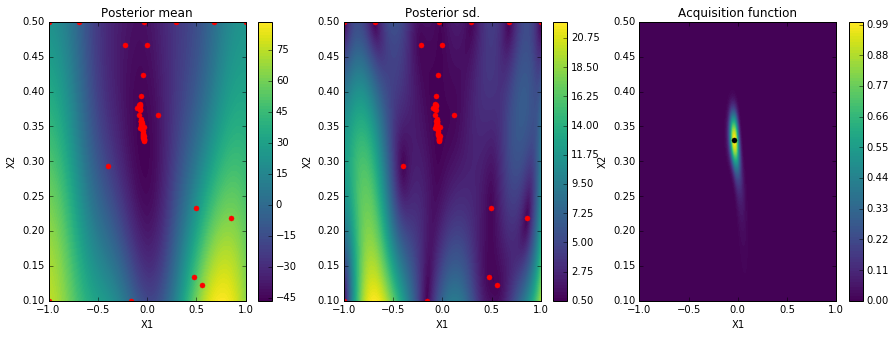

In [39]:
solver.plot_acquisition()

In [40]:
solver.x_opt

array([-0.0596778 ,  0.35848496])

In [44]:
X[0]

array([-1. ,  0.1])

In [108]:
X_test, y = make_parameterized_classification(
    p0, p1,
    n_train_samples, 
    [(mass, np.linspace(0., 2, num=1)), 
     (width, np.linspace(0.5, 2, num=1))])

X_test[0]

array([ 0.0983817,  0.       ,  0.5      ])

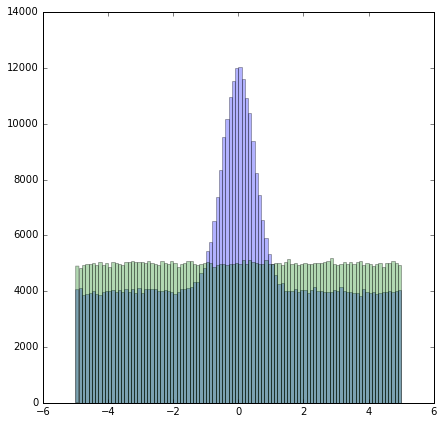

In [109]:
h = plt.hist(X_test[:n_train_samples/2,0], bins=100, alpha=0.3)
_ = plt.hist(X_test[n_train_samples/2:-1,0], bins=h[1], alpha=0.3)

In [130]:
s0 = clf.predict_proba(X_test[n_train_samples/2:-1])
s1 = clf.predict_proba(X_test[0:n_train_samples/2])

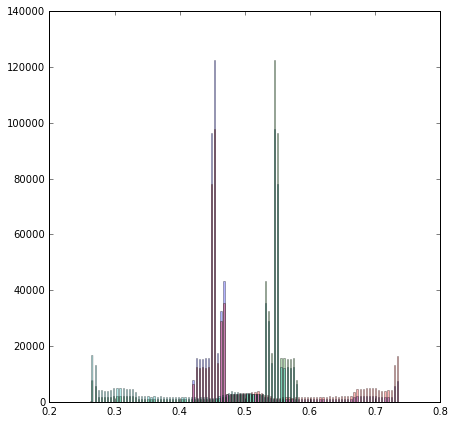

In [131]:
h = plt.hist(s0, bins=100, alpha=0.3)
_ = plt.hist(s1, bins=h[1], alpha=0.3)

In [112]:
s0[s0>.5]

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [124]:
clf_test = MLPRegressor(tol=1e-05, activation="relu", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=1, 
                   max_iter=75)
clf_test.fit(X_test[:,0:1],y)

MLPRegressor(activation='relu', algorithm='l-bfgs', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constant', learning_rate_init=1e-07, max_iter=75,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5, random_state=1,
       shuffle=True, tol=1e-05, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [128]:
s0 = clf.predict_proba(X_test[n_train_samples/2:-1,0:1])
s1 = clf.predict_proba(X_test[0:n_train_samples/2,0:1])

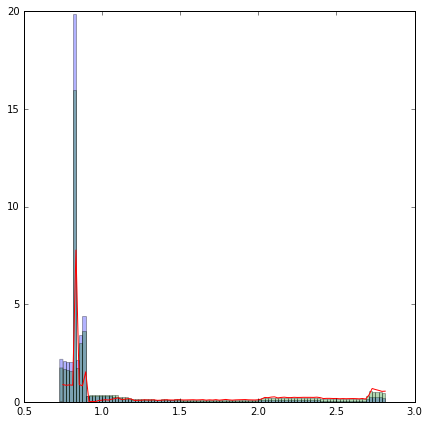

In [172]:
c0, b0, p0 = plt.hist(s0[:,0]/s0[:,1], bins=100, normed=True, alpha=0.3)
c1, b1, p1 = plt.hist(s1[:,0]/s1[:,1], bins=b0, normed=True, alpha=0.3)
plt.plot(b0[1:], np.abs(np.log(c0)-np.log(c1))*(c0+c1))

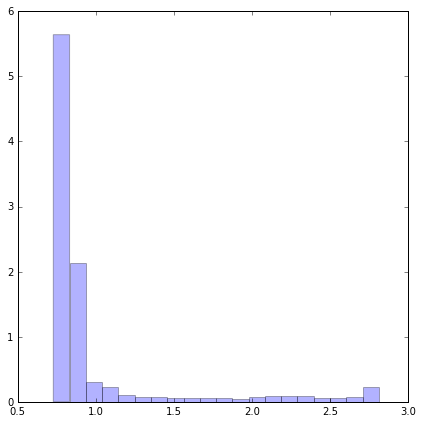

In [165]:
c0, b0, p0 = plt.hist(s0[:,0]/s0[:,1], bins=20, normed=True, alpha=0.3)

n_it =  0
making initial binning
n_it =  1
n_it =  2
n_it =  3
n_it =  4
n_it =  5
n_it =  6
n_it =  7
n_it =  8
n_it =  9
n_it =  10
n_it =  11
n_it =  12
n_it =  13
n_it =  14
n_it =  15
[ 0.7286779   0.74951137  0.77034484  0.79117832  0.81201179  0.81818467
  0.82229993  0.82504343  0.82626276  0.8274821   0.82870143  0.83053043
  0.83978975  0.85367874  0.87451221  0.89534568  0.91617916  0.93701263
  0.9578461   0.97867958  0.99951305  1.02034652  1.04118     1.06201347
  1.08284694  1.10368042  1.12451389  1.14534736  1.16618084  1.18701431
  1.20784778  1.22868125  1.24951473  1.2703482   1.29118167  1.31201515
  1.33284862  1.35368209  1.37451557  1.39534904  1.41618251  1.43701599
  1.45784946  1.47868293  1.49951641  1.52034988  1.54118335  1.56201683
  1.5828503   1.60368377  1.62451725  1.64535072  1.66618419  1.68701767
  1.70785114  1.72868461  1.74951809  1.77035156  1.79118503  1.81201851
  1.83285198  1.85368545  1.87451893  1.8953524   1.91618587  1.93701934
  1.9578

array([ -2.08334732e+00,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   6.17288096e-03,
         4.11525397e-03,   2.74350265e-03,   1.21933451e-03,
         1.21933451e-03,   1.21933451e-03,   1.82900177e-03,
         9.25932144e-03,   1.38889822e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,   2.08334732e-02,   2.08334732e-02,
         2.08334732e-02,

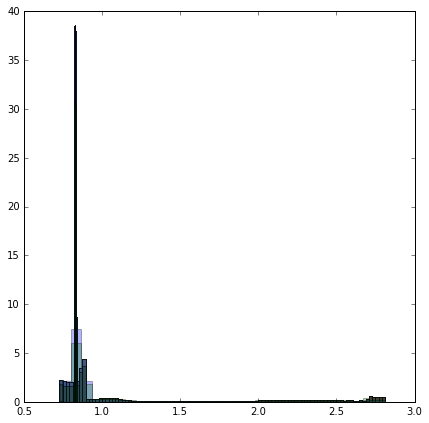

In [204]:
def recursive_info_binning(bins=None, n_it=0, n_max_it=15):
    print("n_it = ", n_it)
    c0, c1 = None, None
    if n_it == n_max_it:
        return bins
    if bins==None:
        print("making initial binning")
        c0, bins, p0 = plt.hist(s0[:,0]/s0[:,1], bins=30, normed=True, alpha=0.3)
        c1, bins, p1 = plt.hist(s1[:,0]/s1[:,1], bins=bins, normed=True, alpha=0.3)
    else:
        c0, bins, p0 = plt.hist(s0[:,0]/s0[:,1], bins=bins, normed=True, alpha=0.3)
        c1, bins, p1 = plt.hist(s1[:,0]/s1[:,1], bins=bins, normed=True, alpha=0.3)
    max_bin_index = np.argmax(np.abs(np.log(c0)-np.log(c1))*(c0+c1))
    first = b0[b0<b0[max_bin_index]]
    last = b0[b0>b0[max_bin_index]]
    extra = np.linspace(first[-1],last[0],4)
    newbins = np.hstack((first,extra[1:3] , last))
    return recursive_info_binning(bins=newbins, n_it=n_it+1)

plt.clf()
rec_bins = recursive_info_binning()
print(rec_bins, rec_bins.size)     
rec_bins-np.roll(rec_bins,1)

[]

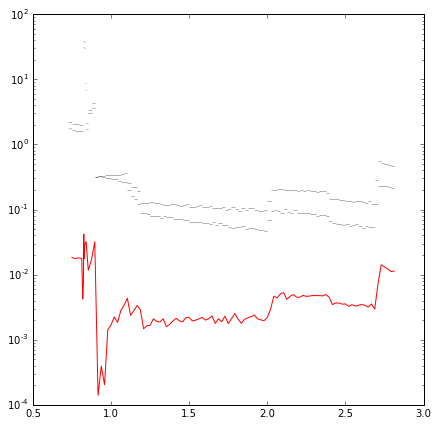

In [227]:
c0, b0, p0 = plt.hist(s0[:,0]/s0[:,1], bins=rec_bins, normed=True, alpha=0.3)
c1, b1, p1 = plt.hist(s1[:,0]/s1[:,1], bins=b0, normed=True, alpha=0.3)
plt.plot(b0[1:], np.abs(np.log(c0)-np.log(c1))*(c0+c1)*(b0[1:]-b0[0:-1]))
plt.semilogy()

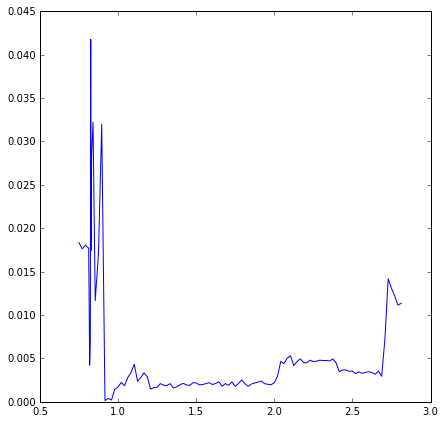

In [226]:
plt.plot(b0[1:], np.abs(np.log(c0)-np.log(c1))*(c0+c1)*(b0[1:]-b0[0:-1]))

In [187]:
blah = None
if blah:
    print('hello')
    blah = 1
else:
    print('not none')
    blah = 2
print(blah)

not none
2


In [183]:
b0, b0[b0<b0[3]], b0[b0>b0[3]], np.linspace(b0[b0<b0[3]][-1],b0[b0>b0[3]][0],4)[1:3]

(array([ 0.7286779 ,  0.74951137,  0.77034484,  0.79117832,  0.81201179,
         0.83284526,  0.85367874,  0.87451221,  0.89534568,  0.91617916,
         0.93701263,  0.9578461 ,  0.97867958,  0.99951305,  1.02034652,
         1.04118   ,  1.06201347,  1.08284694,  1.10368042,  1.12451389,
         1.14534736,  1.16618084,  1.18701431,  1.20784778,  1.22868125,
         1.24951473,  1.2703482 ,  1.29118167,  1.31201515,  1.33284862,
         1.35368209,  1.37451557,  1.39534904,  1.41618251,  1.43701599,
         1.45784946,  1.47868293,  1.49951641,  1.52034988,  1.54118335,
         1.56201683,  1.5828503 ,  1.60368377,  1.62451725,  1.64535072,
         1.66618419,  1.68701767,  1.70785114,  1.72868461,  1.74951809,
         1.77035156,  1.79118503,  1.81201851,  1.83285198,  1.85368545,
         1.87451893,  1.8953524 ,  1.91618587,  1.93701934,  1.95785282,
         1.97868629,  1.99951976,  2.02035324,  2.04118671,  2.06202018,
         2.08285366,  2.10368713,  2.1245206 ,  2.1

In [215]:
blah_x = np.random.uniform(0.,9.,10000)
blah_bins = np.linspace(0,3,30)**2
blah_bins

array([ 0.        ,  0.01070155,  0.04280618,  0.09631391,  0.17122473,
        0.26753864,  0.38525565,  0.52437574,  0.68489893,  0.86682521,
        1.07015458,  1.29488704,  1.54102259,  1.80856124,  2.09750297,
        2.4078478 ,  2.73959572,  3.09274673,  3.46730083,  3.86325803,
        4.28061831,  4.71938169,  5.17954816,  5.66111772,  6.16409037,
        6.68846611,  7.23424495,  7.80142687,  8.39001189,  9.        ])

(array([ 0.12147778,  0.14328148,  0.10278889,  0.13082222,  0.11524815,
         0.1010899 ,  0.11428974,  0.10092   ,  0.09014641,  0.10869064,
         0.0992291 ,  0.10400773,  0.10652667,  0.11247942,  0.10826667,
         0.11665484,  0.10080673,  0.11026444,  0.11743694,  0.11548775,
         0.11623577,  0.10996021,  0.11192568,  0.11650733,  0.11251474,
         0.11231656,  0.11019392,  0.11111394,  0.11492027]),
 array([ 0.        ,  0.01070155,  0.04280618,  0.09631391,  0.17122473,
         0.26753864,  0.38525565,  0.52437574,  0.68489893,  0.86682521,
         1.07015458,  1.29488704,  1.54102259,  1.80856124,  2.09750297,
         2.4078478 ,  2.73959572,  3.09274673,  3.46730083,  3.86325803,
         4.28061831,  4.71938169,  5.17954816,  5.66111772,  6.16409037,
         6.68846611,  7.23424495,  7.80142687,  8.39001189,  9.        ]),
 <a list of 29 Patch objects>)

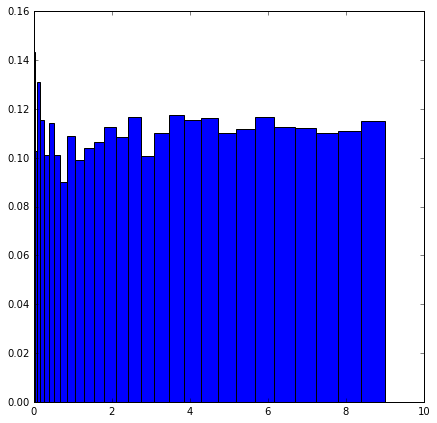

In [216]:
plt.hist(blah_x, bins=blah_bins, normed=True)

In [224]:
b0.size, b0[0:-1].size,  b0[1:].size

(108, 107, 107)